In [558]:
import requests
import json
import tweepy
import re
import csv

In [559]:
import time
import pandas as pd
import nltk
from nltk.stem.porter import *
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Using vaderSentiment for sentiment analysis

In [560]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [561]:
import os
os.getcwd()

'C:\\Users\\jain.k.5'

In [562]:
 analyser.polarity_scores("The movie is VERY BAD")

{'neg': 0.568, 'neu': 0.432, 'pos': 0.0, 'compound': -0.7398}

In [563]:
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1

In [564]:
sentiment_analyzer_scores("The movie is VERY BAD!!!")

-1

## Using TextBlob for sentiment analysis

In [263]:
from textblob import TextBlob

In [270]:
import nltk
#nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jain.k.5\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [565]:
wiki = TextBlob("This is VERY BAD!!!")

In [566]:
wiki.tags

[('This', 'DT'), ('is', 'VBZ'), ('VERY', 'RB'), ('BAD', 'JJ')]

In [567]:
wiki.words

WordList(['This', 'is', 'VERY', 'BAD'])

In [568]:
wiki.sentiment

Sentiment(polarity=-1.0, subjectivity=0.8666666666666667)

In [569]:
def sentiment_analyzer_scores_textblob(text):
    score = TextBlob(text).sentiment.polarity
    lb = score
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1

## Connecting with Twitter to search for tweets

In [570]:
# Store OAuth authentication credentials in relevant variables
access_token = "150560718-AQVb7cUyifl5QCwulJKHhc2ike4Ojyg7GwFVMiO1"
access_token_secret = "eDauHcE9dDOlXK4EzbgNiz7tKq0PRcpoIqSquUaLtxTNj"
consumer_key = "linPRgOLXtom98ieHl8kHnSEe"
consumer_secret = "rdQ17FgmzvT3XDMOUAujfqfasO4rEN8P3zjViXxLjpSQZxlgup"

In [571]:
# Pass OAuth details to tweepy's OAuth handler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [627]:
api = tweepy.API(auth)
hashtag_phrase = "#covid19"
count = 200

In [628]:
# A glimpse
#for each tweet matching our hashtags, write relevant info to the spreadsheet
for tweet in tweepy.Cursor(api.search, q=hashtag_phrase+' -filter:retweets', lang="en", tweet_mode='extended').items(5):
    print(tweet.full_text.replace('\n',' '))
    print('\n')
    print("TextBlob Sentiment Analysis: ", TextBlob(tweet.full_text.replace('\n',' ')).sentiment)
    print("vaderSentiment Sentiment Analysis: ", analyser.polarity_scores(tweet.full_text.replace('\n',' ')))
    print('\n')

Dats shows that Average Testing Capacity of Sindh is increased in Pakistan &amp; Inter-provincial comparison chart says Sindh has tested more people than Punjab. This is why Sindh is leading in combating #Covid19 https://t.co/xMyR5DpI2Q


TextBlob Sentiment Analysis:  Sentiment(polarity=0.175, subjectivity=0.44999999999999996)
vaderSentiment Sentiment Analysis:  {'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compound': 0.2732}


Employ GM is a new service that has been launched to help bridge skills gaps, reduce redundancies and help people get back into work across Greater Manchester in light of #COVID19.   Find out more https://t.co/4ptWFTeblH   #EmployGM #Skills #Employment #BusinessSupport https://t.co/qHTG7nzwgj


TextBlob Sentiment Analysis:  Sentiment(polarity=0.30727272727272725, subjectivity=0.43090909090909085)
vaderSentiment Sentiment Analysis:  {'neg': 0.0, 'neu': 0.793, 'pos': 0.207, 'compound': 0.8126}


Working From Home: Outlook Email Alternatives https://t.co/RXabbYlMCM #covi

In [629]:
def list_tweets(hashtag_phrase, count, prt = False):
    tweets = tweepy.Cursor(api.search, q=hashtag_phrase+' -filter:retweets', lang="en", tweet_mode='extended').items(count)
    tw = []
    for t in tweets:
        tw.append(t.full_text.replace('\n',' ').lower())
        if prt:
            print(t.full_text.replace('\n',' ').lower())
            print()
    return tw

In [630]:
public_tweets = list_tweets(hashtag_phrase, count)
len(public_tweets)

1000

In [631]:
public_tweets[3]

"if you haven't yet managed to donate to the cardinal's lenten appeal, please do. anything you give can #helpushelpothers during this time of #covid19  https://t.co/jfwialph9q thank you  ðŸ“¸mazur/@catholicew https://t.co/yirliekta0"

In [632]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

In [633]:
def replace_pattern(input_txt, pattern, replace_text):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, replace_text, input_txt)        
    return input_txt

In [634]:
def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")  
    # remove amp with and
    lst = np.vectorize(replace_pattern)(lst, "amp", "and")      
    return lst

In [635]:
def clean_hashtags(lst):
    lst = np.vectorize(remove_pattern)(lst, "#[A-Za-z0-9]+")
    lst = np.vectorize(remove_pattern)(lst, "#[\w]*")
    return lst

In [636]:
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=30,
        max_font_size=200).generate(all_words)

    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

In [637]:
import numpy as np
public_tweets = clean_tweets(public_tweets)
public_tweets_without_hashtags = clean_hashtags(public_tweets)
text = public_tweets_without_hashtags[3]
text

"if you haven't yet managed to donate to the cardinal's lenten appeal, please do. anything you give can  during this time of    thank you  ðŸ“¸mazur/ "

In [638]:
public_tweets[3]

"if you haven't yet managed to donate to the cardinal's lenten appeal, please do. anything you give can #helpushelpothers during this time of #covid19   thank you  ðŸ“¸mazur/ "

In [639]:
print(TextBlob(str(clean_hashtags(text))).sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


In [640]:
print(analyser.polarity_scores(str(clean_hashtags(text))))

{'neg': 0.0, 'neu': 0.839, 'pos': 0.161, 'compound': 0.5859}


In [641]:
#score_dict = analyser.polarity_scores(text)
#del score_dict['compound']
#sentiment = max(score_dict.items(), key = lambda x: x[1])
#print("Sentiment: ", sentiment[1])
#print("Sentiment Score: ", sentiment[0])

In [642]:
def modified_sentiment_analyzer_scores(text):
    """ Modified Sentiment Analysis Score from VaderSentiment"""
    score = analyser.polarity_scores(text)
    del score['compound']
    sentiment = max(score.items(), key = lambda x: x[1])
    if sentiment[0] == "pos":
        return 1
    elif sentiment[0] == "neu":
        return 0
    else:
        return -1

In [643]:
def anl_tweets(lst, title='Tweets Sentiment', engl=True ):
    sents = []
    for tw in lst:
        try:
            st = sentiment_analyzer_scores(tw)
            sents.append(st)
        except:
            sents.append(0)
    ax = sns.distplot(
        sents,
        kde=False,
        bins=3)
    ax.set(xlabel='Negative                Neutral                 Positive',
           ylabel='#Tweets',
          title="Tweets of @"+title)
    return sents

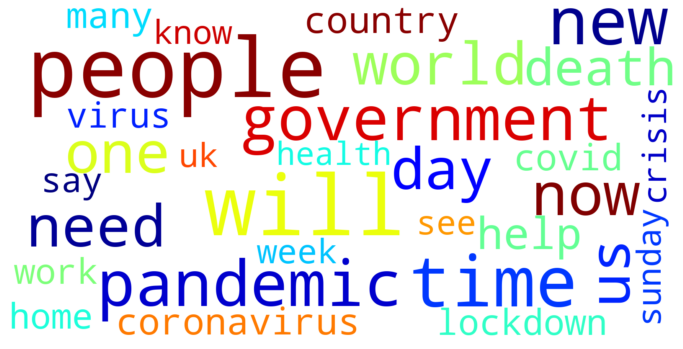

In [644]:
word_cloud(public_tweets_without_hashtags)

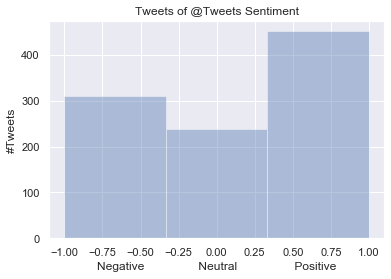

In [645]:
df_tws = pd.DataFrame()
df_tws['complete text'] = clean_tweets(public_tweets)
df_tws['text'] =  clean_hashtags(clean_tweets(public_tweets_without_hashtags))
df_tws['sent'] = anl_tweets(public_tweets_without_hashtags)

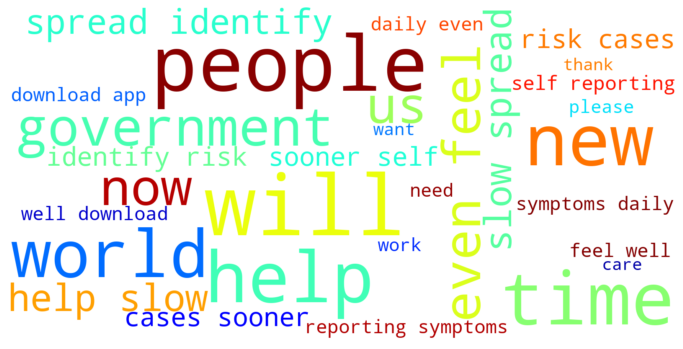

In [646]:
# Words in positive tweets
tws_pos = df_tws['text'][df_tws['sent'] == 1]
word_cloud(tws_pos)

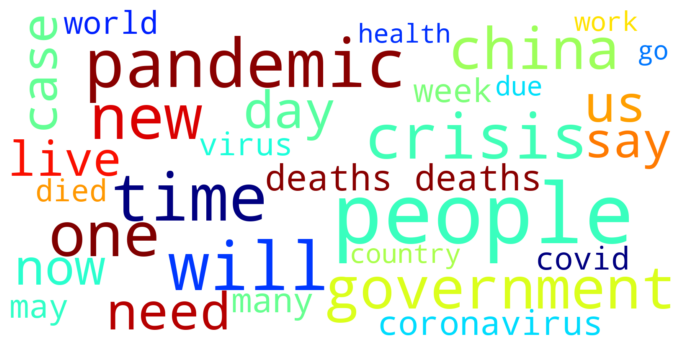

In [647]:
# Words in negative tweets
tws_neg = df_tws['text'][df_tws['sent'] == -1]
word_cloud(tws_neg)

In [648]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [649]:
# extracting hashtags from positive tweets

HT_positive = hashtag_extract(df_tws['complete text'][df_tws['sent'] == 1])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(df_tws['complete text'][df_tws['sent'] == -1])

# unnesting list
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])

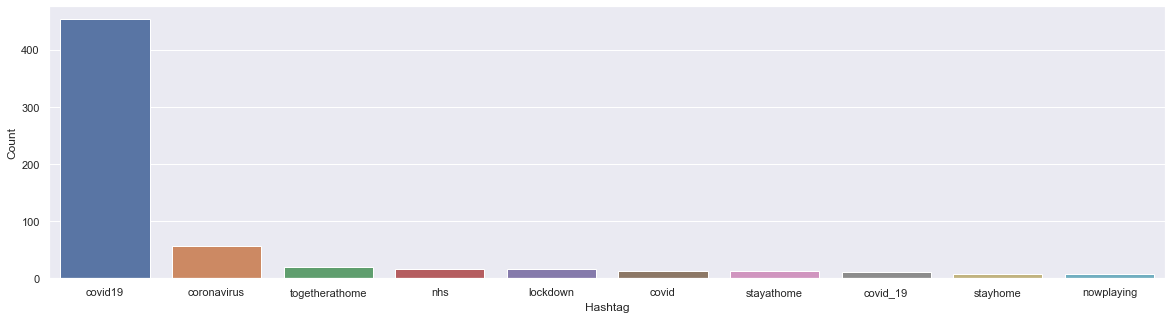

In [650]:
# Positive hashtags

a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

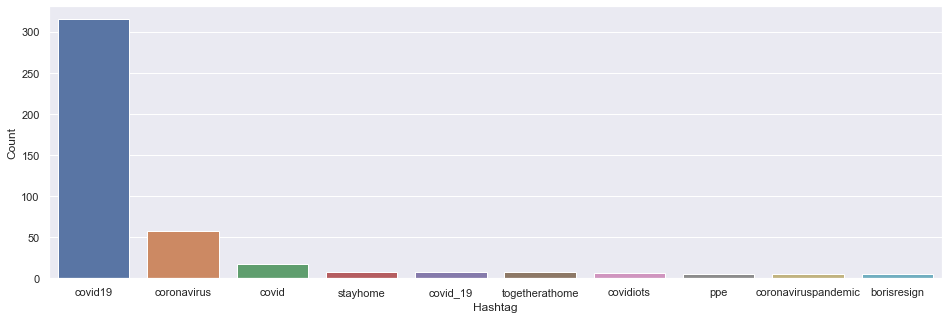

In [651]:
# Negative Tweets

b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### End of the script

In [30]:

"""
INPUTS:
    consumer_key, consumer_secret, access_token, access_token_secret: codes 
    telling twitter that we are authorized to access this data
    hashtag_phrase: the combination of hashtags to search for
OUTPUTS:
    none, simply save the tweet info to a spreadsheet
"""
def search_for_hashtags(consumer_key, consumer_secret, access_token, access_token_secret, hashtag_phrase):
    
    #create authentication for accessing Twitter
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    #initialize Tweepy API
    api = tweepy.API(auth)
    
    #get the name of the spreadsheet we will write to
    fname = '_'.join(re.findall(r"#(\w+)", hashtag_phrase))

    #open the spreadsheet we will write to
    with open('%s.csv' % (fname), 'w') as file:

        w = csv.writer(file)

        #write header row to spreadsheet
        w.writerow(['timestamp', 'tweet_text', 'username', 'followers_count'])

        #for each tweet matching our hashtags, write relevant info to the spreadsheet
        for tweet in tweepy.Cursor(api.search, q=hashtag_phrase+' -filter:retweets', \
                                   lang="en", tweet_mode='extended').items(200):
            w.writerow([tweet.created_at, tweet.full_text.replace('\n',' ').encode("utf-8"), tweet.user.screen_name.encode("utf-8"), tweet.user.followers_count])

In [32]:
# Store OAuth authentication credentials in relevant variables
access_token = "150560718-AQVb7cUyifl5QCwulJKHhc2ike4Ojyg7GwFVMiO1"
access_token_secret = "eDauHcE9dDOlXK4EzbgNiz7tKq0PRcpoIqSquUaLtxTNj"
consumer_key = "linPRgOLXtom98ieHl8kHnSEe"
consumer_secret = "rdQ17FgmzvT3XDMOUAujfqfasO4rEN8P3zjViXxLjpSQZxlgup"
    
hashtag_phrase = input('Hashtag Phrase ')

if __name__ == '__main__':
    search_for_hashtags(consumer_key, consumer_secret, access_token, access_token_secret, hashtag_phrase)

Hashtag Phrase #covid
